# DenoiseNet

DenoiseNet is a neural network that takes in a raw, uncleaned pointcloud, and outputs a clean pointcloud with a lot less noisy points. This notebook will walk you through the intuition of designing a model to perform deeplearning on this specific task of per-point noise classification

## Where to Start

When looking to create a model for a certain task, we first need to understand the data that will power the model. Since the task of our model is to classify each point in a point cloud, we will need a large dataset of point clouds. A point cloud will be defined as a collection of points of size `N x 3`, where N is equal to the number of points and each point has an x, y, and z value

### Inputs and Outputs

To understand how our dataset will look, we need to decide what our model should accept as input, and what our model should output as a result. For an input, our model will take in a point cloud. This `input` can be expected to be an unclean point cloud, where many of the points that make up the object are actually outliers that should not be part of the point cloud. The `output` should be a classification for every single point of the input. This will be of shape `N x 1` where each point has either a 0 for a clean point, or 1 for a noisy point. This output will allow users to effectively denoise their input point clouds 

## Dataset

With an understanding of what our input and output should be, we can now look into creating a dataset. Each entry in our dataset should just match our input, and output. This data can be obtained through the creation of a synthetic dataset sampled from the ModelNet10 dataset. ModelNet10 is a dataset made up of mesh files of 10 different types of objects. Using these mesh files, it is possible to sample points to turn the dataset into a collection of point cloud files. From here, we can create our noisy input point clouds as well as our output classification labels. This will be done by corrupting our point clouds with noise, and recording which points we added as noise for the labels

Before starting this process, `lets download the ModelNet10 dataset`



In [145]:
import os
import requests
import zipfile
import shutil
import stat

def download_modelnet10(url: str, destination: str, cleanup: bool):
    """Download the modelnet10 dataset and delete unneeded files if cleanup is True"""

    if not os.path.isdir("dataset"):
        os.makedirs("dataset")

    if os.path.exists("dataset/ModelNet10"):
        return

    filename = url.split('/')[-1].replace(" ", "_")
    file_path = os.path.join(destination, filename)

    r = requests.get(url, stream=True)
    if r.ok:
        print(f"saving to \"{os.path.abspath(file_path)}\"")
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 8):
                if chunk:
                    f.write(chunk)
                    f.flush()
                    os.fsync(f.fileno())
    else:  # HTTP status code 4XX/5XX
        print("Download failed: status code {}\n{}".format(r.status_code, r.text))

    with zipfile.ZipFile("dataset/ModelNet10.zip", 'r') as zip_ref:
        zip_ref.extractall("dataset")

    if cleanup:
        os.remove("dataset/ModelNet10.zip")
        os.remove("dataset/ModelNet10/README.txt")
        directory_path = "dataset/__MACOSX"
        shutil.rmtree(directory_path, onerror=lambda func, path, exc: os.chmod(path, stat.S_IWRITE)) # avoid WIN10 permission error

In [121]:
URL = "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip"
DESTINATION = "dataset"

download_modelnet10(url=URL, destination=DESTINATION, cleanup=True)

To understand what we are working with, let's plot some information about ModelNet10

In [122]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_modelnet_categories(modelnet_path: str, text: bool=True):
    """graph the amount of examples for each category in the dataset"""
    categories = []
    total_files = []

    for folder in os.listdir(modelnet_path):
        subfolder = os.path.join(modelnet_path, folder)
        train_files = len(os.listdir(os.path.join(subfolder, "train")))
        test_files = len(os.listdir(os.path.join(subfolder, "test")))
        total = train_files + test_files
        
        categories.append(folder.replace("_", " "))
        total_files.append(total)

    plt.figure(figsize=(12, 6))
    plt.bar(categories, total_files, color='skyblue')
    plt.xlabel('Categories')
    plt.ylabel('Total Files')
    plt.title('Total Files per Category in ModelNet Dataset')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    if text:
        df = pd.DataFrame([total_files], columns=categories)
        df['Total'] = df.sum(axis=1)
        df.index = ['Amount']
        display(df)


        

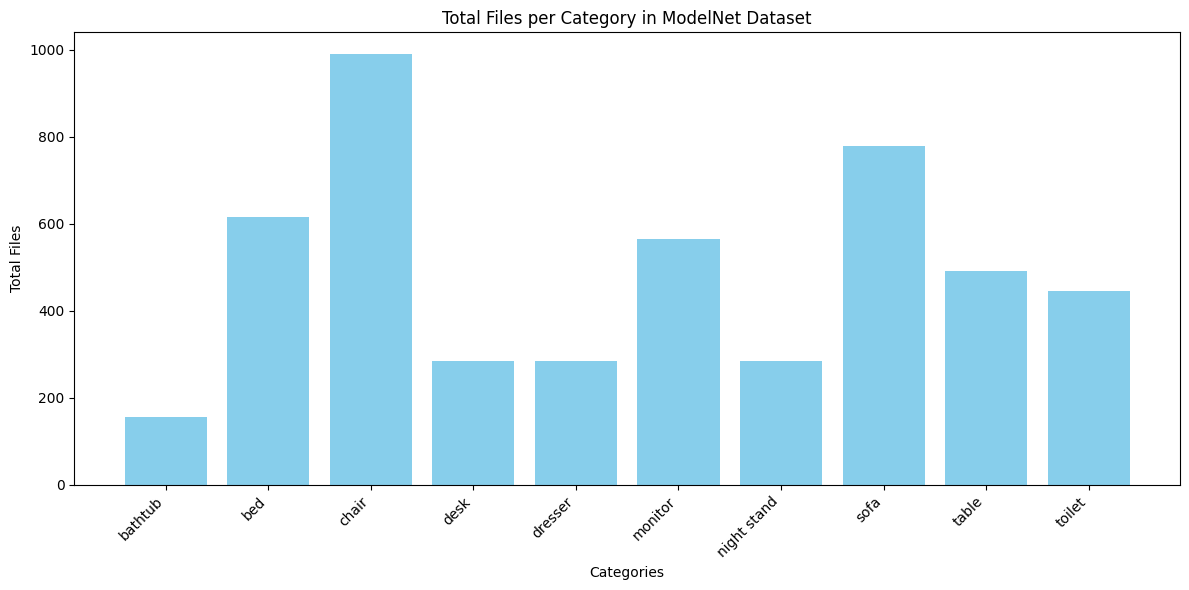

,bathtub,bed,chair,desk,dresser,monitor,night stand,sofa,table,toilet,Total
Amount,156,617,991,286,286,565,286,780,492,446,4905


In [123]:
plot_modelnet_categories("C:/Users/jwilder/home/data/ModelNet10")

Let's display an example from the ModelNet dataset

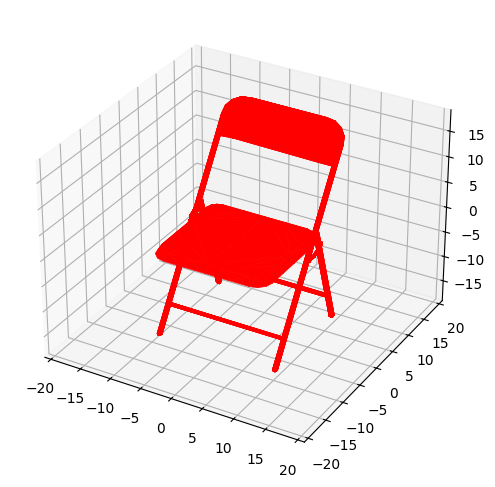

In [125]:
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def display_mesh(mesh_path):
    mesh = trimesh.load(mesh_path)

    vertices = mesh.vertices
    faces = mesh.faces

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    poly3d = [[vertices[vertice] for vertice in face] for face in faces]
    ax.add_collection3d(Poly3DCollection(poly3d, facecolors='red', linewidths=0.5, edgecolors='r'))

    # Set correct scaling
    scale = vertices.flatten()
    ax.auto_scale_xyz(scale, scale, scale)

    plt.show()

mesh_path = "dataset/ModelNet10/chair/train/chair_0001.off"
display_mesh(mesh_path)


### Synthetic Dataset

Now that we have the base ModelNet10 dataset, we can manipulate it to be in the format that we need. As you see above, we currently have mesh files. Mesh files can be thought of as a list of vertices and edges that make up a 3D object. We will need to sample points along the faces of the object to convert the mesh to a point cloud. Let's go ahead and make a class to handle this, as well as all the other helper functions we will need to create the synthetic dataset

In [146]:
import open3d as o3d
import numpy as np
import torch


class DatasetUtils:
    
    @staticmethod
    def mesh_to_pointcloud(file_path: str, num_points: int = 4096) -> torch.Tensor:
        """Convert a mesh file to a point cloud tensor by randomly sampling points"""
        mesh = o3d.io.read_triangle_mesh(file_path)
        pcd = mesh.sample_points_uniformly(number_of_points=num_points)
        points = np.asarray(pcd.points, dtype=np.float32)
        centered_pointcloud = points - np.mean(points, axis=0)
        norm_pointcloud = centered_pointcloud / np.max(np.linalg.norm(centered_pointcloud, axis=1))

        return torch.from_numpy(norm_pointcloud)
    
    @staticmethod
    def add_noise_to_pcd(pcd: torch.tensor, num_noise_points: int, offset_strength: float = .1):
        """Obfuscate a point cloud by adding random noisy points and return binary labels"""
        num_points = pcd.size(0)
        noise_points = []

        for _ in range(num_noise_points):
            random_idx = torch.randint(0, num_points, (1,)).item()
            random_offset = torch.FloatTensor(3).uniform_(-offset_strength, offset_strength)
            noisy_point = pcd[random_idx] + random_offset
            noise_points.append(noisy_point)

        noise_points = torch.stack(noise_points)
        combined_points = torch.vstack((pcd, noise_points))

        clean_labels = torch.ones(num_points, dtype=torch.float32)
        noise_labels = torch.zeros(num_noise_points, dtype=torch.float32)
        combined_labels = torch.cat((clean_labels, noise_labels))

        return combined_points, combined_labels
    
    @staticmethod
    def add_valid_noise_to_pcd(pcd: torch.Tensor, num_noise_points: int, offset_strength: float = 0.5) -> torch.Tensor:
        """Add random noise points to the point cloud, restricted to spots that are not valid clean point locations"""
        min_bound = torch.min(pcd, dim=0)[0].float()
        max_bound = torch.max(pcd, dim=0)[0].float()

        noise_points = torch.empty((num_noise_points, 3))

        for i in range(num_noise_points):
            side = torch.randint(0, 6, (1,)).item()

            # Point must be outside of bounding box
            if side == 0:
                noise_points[i, 0] = min_bound[0] - offset_strength * torch.rand(1).item()
                noise_points[i, 1] = torch.rand(1).item() * (max_bound[1] - min_bound[1]) + min_bound[1]
                noise_points[i, 2] = torch.rand(1).item() * (max_bound[2] - min_bound[2]) + min_bound[2]
            elif side == 1:
                noise_points[i, 0] = max_bound[0] + offset_strength * torch.rand(1).item()
                noise_points[i, 1] = torch.rand(1).item() * (max_bound[1] - min_bound[1]) + min_bound[1]
                noise_points[i, 2] = torch.rand(1).item() * (max_bound[2] - min_bound[2]) + min_bound[2]
            elif side == 2:
                noise_points[i, 0] = torch.rand(1).item() * (max_bound[0] - min_bound[0]) + min_bound[0]
                noise_points[i, 1] = min_bound[1] - offset_strength * torch.rand(1).item()
                noise_points[i, 2] = torch.rand(1).item() * (max_bound[2] - min_bound[2]) + min_bound[2]
            elif side == 3:
                noise_points[i, 0] = torch.rand(1).item() * (max_bound[0] - min_bound[0]) + min_bound[0]
                noise_points[i, 1] = max_bound[1] + offset_strength * torch.rand(1).item()
                noise_points[i, 2] = torch.rand(1).item() * (max_bound[2] - min_bound[2]) + min_bound[2]
            elif side == 4:
                noise_points[i, 0] = torch.rand(1).item() * (max_bound[0] - min_bound[0]) + min_bound[0]
                noise_points[i, 1] = torch.rand(1).item() * (max_bound[1] - min_bound[1]) + min_bound[1]
                noise_points[i, 2] = min_bound[2] - offset_strength * torch.rand(1).item()
            else:
                noise_points[i, 0] = torch.rand(1).item() * (max_bound[0] - min_bound[0]) + min_bound[0]
                noise_points[i, 1] = torch.rand(1).item() * (max_bound[1] - min_bound[1]) + min_bound[1]
                noise_points[i, 2] = max_bound[2] + offset_strength * torch.rand(1).item()

        combined_points = torch.vstack((pcd, noise_points))  # Shape: (N + num_noise_points, 3)

        return combined_points
    

    @staticmethod
    def visualize_bounding_box(pcd: torch.Tensor):
        """Visualize a point cloud and its bounding box"""

        pcd_np = pcd.cpu().numpy()
        pcd_o3d = o3d.geometry.PointCloud()
        pcd_o3d.points = o3d.utility.Vector3dVector(pcd_np)

        min_bound = torch.min(pcd, dim=0)[0].float()
        max_bound = torch.max(pcd, dim=0)[0].float()

        bbox_corners = torch.tensor([[min_bound[0], min_bound[1], min_bound[2]],
                                        [max_bound[0], min_bound[1], min_bound[2]],
                                        [max_bound[0], max_bound[1], min_bound[2]],
                                        [min_bound[0], max_bound[1], min_bound[2]],
                                        [min_bound[0], min_bound[1], max_bound[2]],
                                        [max_bound[0], min_bound[1], max_bound[2]],
                                        [max_bound[0], max_bound[1], max_bound[2]],
                                        [min_bound[0], max_bound[1], max_bound[2]]]).float()

        lines = [
            [0, 1], [1, 2], [2, 3], [3, 0],
            [4, 5], [5, 6], [6, 7], [7, 4],
            [0, 4], [1, 5], [2, 6], [3, 7] 
        ]

        line_set = o3d.geometry.LineSet()
        line_set.points = o3d.utility.Vector3dVector(bbox_corners.numpy())
        line_set.lines = o3d.utility.Vector2iVector(lines)
        line_set.paint_uniform_color([1, 0, 0])

        o3d.visualization.draw_geometries([pcd_o3d, line_set], window_name="Point Cloud and Bounding Box")

    
    @staticmethod
    def generate_labels(pcd: torch.Tensor, num_noise_points: int):
        """Generate binary labels for the original and noisy points in a point cloud"""
        num_points = pcd.size(0)

        clean_labels = torch.ones(num_points, dtype=torch.float32)
        noise_labels = torch.zeros(num_noise_points, dtype=torch.float32)
        combined_labels = torch.cat((clean_labels, noise_labels))  # Shape: (N + num_noise_points)

        return combined_labels
    
    
    @staticmethod
    def shuffle_tensors(input_tensor: torch.Tensor, output_tensor: torch.Tensor):
        """Shuffle both the input point cloud and the output labels by the same permutation"""
        assert input_tensor.size(0) == output_tensor.size(0), "Input and output must have the same number of points"
        
        perm = torch.randperm(input_tensor.size(0))
        
        input_shuffled = input_tensor[perm]
        output_shuffled = output_tensor[perm]
        
        return input_shuffled, output_shuffled

    
    @staticmethod
    def visualize_pointcloud(pcd: torch.Tensor):
        """Run an interactive visualization of a point cloud tensor"""
        pcd_np = pcd.cpu().numpy()
        pcd_o3d = o3d.geometry.PointCloud()
        pcd_o3d.points = o3d.utility.Vector3dVector(pcd_np)
        o3d.visualization.draw_geometries([pcd_o3d], window_name="Point Cloud Visualization")

    @staticmethod
    def visualize_noisy_pointcloud(pcd: torch.Tensor, labels: torch.Tensor):
        """Run an interactive visualization of a point cloud tensor with points labelled"""
        pcd_np = pcd.cpu().numpy()

        pcd_o3d = o3d.geometry.PointCloud()
        pcd_o3d.points = o3d.utility.Vector3dVector(pcd_np)

        colors = torch.zeros((labels.size(0), 3))

        colors[labels == 0] = torch.tensor([1.0, 0.0, 0.0])  # Red for noisy points
        colors[labels == 1] = torch.tensor([0.0, 0.0, 1.0])  # Blue for clean points

        pcd_o3d.colors = o3d.utility.Vector3dVector(colors.numpy())

        o3d.visualization.draw_geometries([pcd_o3d], window_name="Point Cloud Visualization")


    @staticmethod
    def plot_example(noisy_pcd: torch.Tensor, labels: torch.Tensor, base_color: list[float] = [0.3, 0.6, 0.9], noise_color: list[float] = [1.0, 0.0, 0.0]):
        """plot the noisy point cloud, labeled noisy point cloud, and the clean point cloud"""

        noisy_pcd_np = noisy_pcd.numpy()
        labels_np = labels.numpy()
        noise_mask = labels_np == 0
        clean_mask = labels_np == 1

        fig = plt.figure(figsize=(15, 5))

        # Noisy Point Cloud
        ax1 = fig.add_subplot(1, 3, 1, projection='3d')
        ax1.scatter(noisy_pcd_np[:, 0], noisy_pcd_np[:, 1], noisy_pcd_np[:, 2], color=base_color, s=1)
        ax1.set_title('Noisy Point Cloud')
        ax1.set_xlim(-1, 1)
        ax1.set_ylim(-1, 1)
        ax1.set_zlim(-1, 1)

        # Noisy Point Cloud with Colors
        ax2 = fig.add_subplot(1, 3, 2, projection='3d')
        ax2.scatter(noisy_pcd_np[clean_mask, 0], noisy_pcd_np[clean_mask, 1], noisy_pcd_np[clean_mask, 2], color=base_color, s=1)  # Clean points
        ax2.scatter(noisy_pcd_np[noise_mask, 0], noisy_pcd_np[noise_mask, 1], noisy_pcd_np[noise_mask, 2], color=noise_color, s=1)  # Noise points
        ax2.set_title('Labeled Noisy Point Cloud')
        ax2.set_xlim(-1, 1)
        ax2.set_ylim(-1, 1)
        ax2.set_zlim(-1, 1)

        # Clean Point Cloud
        clean_pcd = noisy_pcd[labels_np == 1]
        ax3 = fig.add_subplot(1, 3, 3, projection='3d')
        ax3.scatter(clean_pcd[:, 0], clean_pcd[:, 1], clean_pcd[:, 2], color=base_color, s=1)
        ax3.set_title('Clean Point Cloud')
        ax3.set_xlim(-1, 1)
        ax3.set_ylim(-1, 1)
        ax3.set_zlim(-1, 1)

        plt.tight_layout()
        plt.show()

Now we have a large range of helper functions to help us see our data. Let's go ahead and create one sample for our dataset manually so we can see if it looks good. If you want a closer look, set `INTERACTIVE_VISUALIZATION` to `True`. What we should see is our input to the model, a point cloud with noise classified as red which can be created from the output of our model, and finally the point cloud with all the noisy points removed

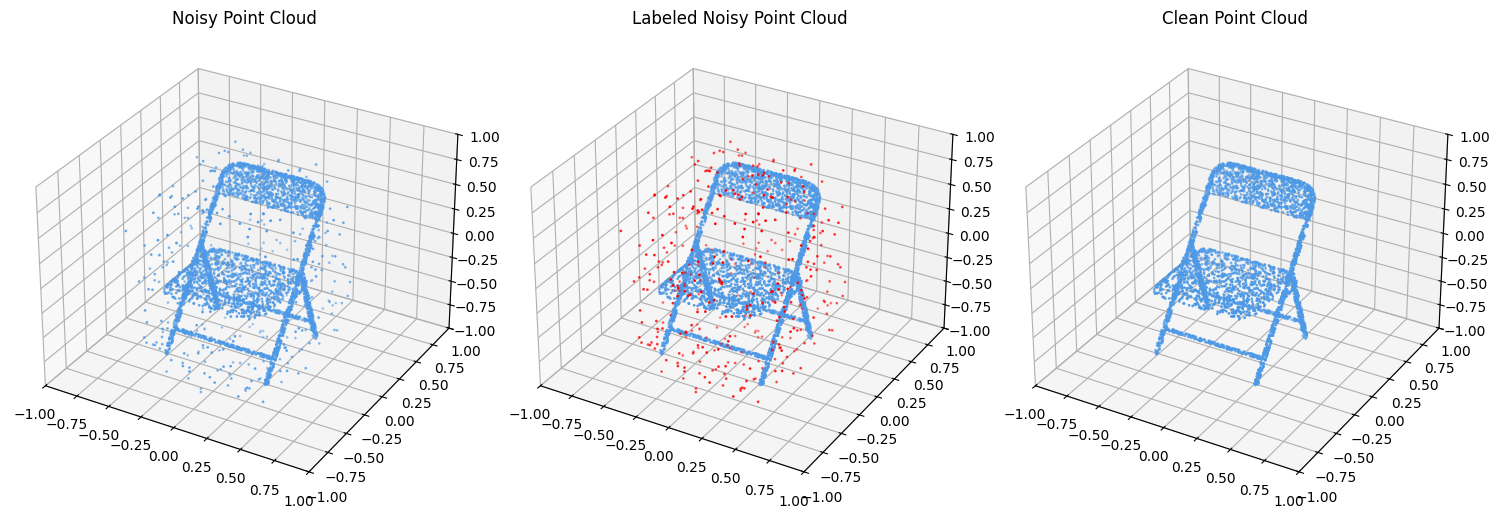

In [147]:
INTERACTIVE_VISUALIZATION = False

original_pcd = DatasetUtils.mesh_to_pointcloud("dataset/ModelNet10/chair/train/chair_0001.off")
noisy_pcd = DatasetUtils.add_valid_noise_to_pcd(original_pcd, 400, .2)
labels = DatasetUtils.generate_labels(original_pcd, 400)
noisy_pcd, labels = DatasetUtils.shuffle_tensors(noisy_pcd, labels)


DatasetUtils.plot_example(noisy_pcd, labels)
if INTERACTIVE_VISUALIZATION:
    DatasetUtils.visualize_noisy_pointcloud(noisy_pcd, labels)



### Synthetic Dataset Creation

We can now use our helper functions to go through each mesh file, extract a point cloud, corrupt the point cloud by adding noise, and label each point as either clean or noisy. This will leave us with a proper dataset for the task at hand

In [148]:
from torch.utils.data import Dataset
from tqdm import tqdm

class PointCloudDataset(Dataset):
    def __init__(self, root_dir: str):
        self.root_dir = root_dir
        self.pointcloud_files = []
        self.data = []
        self.length = 0
        self._initialize_dataset()

    def _initialize_dataset(self):
        """sample point clouds, obfuscate point cloud with noise, and generate labels for each sample"""
        for folder in os.listdir(self.root_dir):

            if folder == ".DS_Store": continue

            subfolder = os.path.join(self.root_dir, folder)
            train_folder = os.path.join(subfolder, "train")
            test_folder = os.path.join(subfolder, "test")

            for file in os.listdir(train_folder):
                file_path = os.path.join(train_folder, file)
                if not file_path.endswith(".off"): continue
                self.pointcloud_files.append(os.path.normpath(file_path))

            for file in os.listdir(test_folder):
                file_path = os.path.join(test_folder, file)
                if not file_path.endswith(".off"): continue
                self.pointcloud_files.append(os.path.normpath(file_path))


        self.length = len(self.pointcloud_files)

        for file in tqdm(self.pointcloud_files, desc="Generating point cloud dataset"):
            pcd = DatasetUtils.mesh_to_pointcloud(file)
            noisy_pcd = DatasetUtils.add_valid_noise_to_pcd(pcd, 500, .2)
            labels = DatasetUtils.generate_labels(pcd, 500)
            #noisy_pcd, labels = PointCloudUtils.shuffle_tensors(noisy_pcd, labels)
            self.data.append({"input": noisy_pcd, "output": labels})

        self.pointcloud_files.clear()

    def __len__(self) -> int:
        return self.length

    def __getitem__(self, index: int) -> str:
        return self.data[index]



Instantiate the PointCloudDataset and save it to file. If the dataset file already exists, load it from file to save time

In [150]:
import pickle

if os.path.exists("dataset/dataset.pickle"):
    print("Loading existing dataset")
    with open('dataset/dataset.pickle', 'rb') as handle:
        dataset = pickle.load(handle)
else:
    print("Generating new dataset")
    dataset = PointCloudDataset("dataset/ModelNet10")
    with open('dataset/dataset.pickle', 'wb') as handle:
        pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

Loading existing dataset


Let's visualize a few examples from the dataset

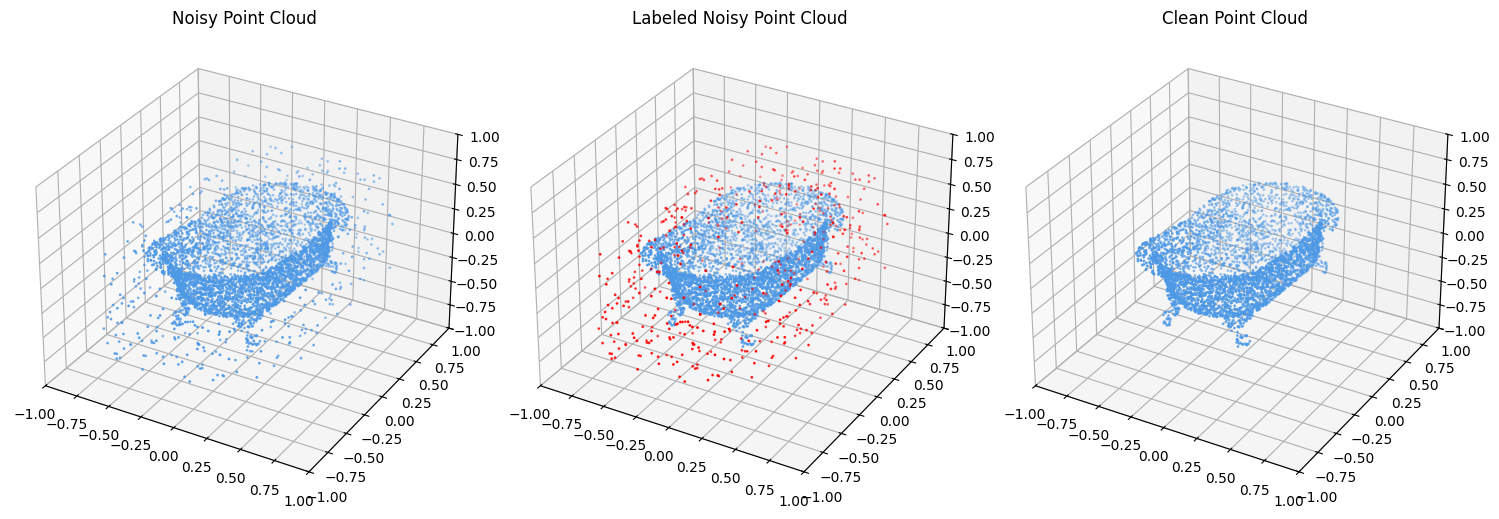

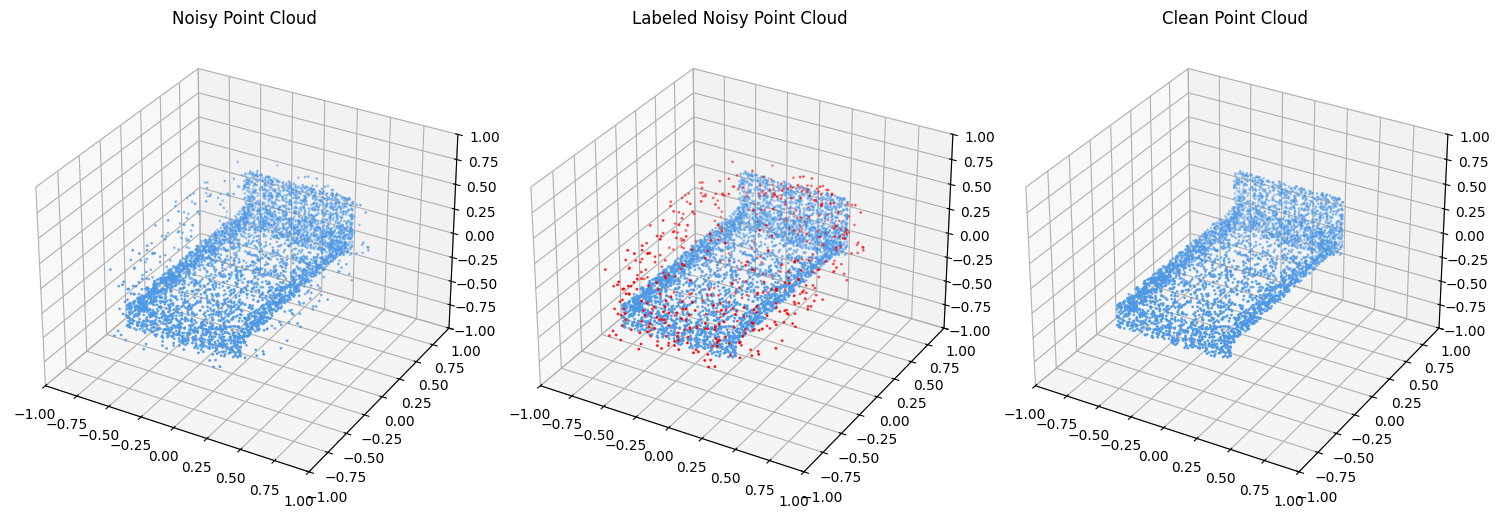

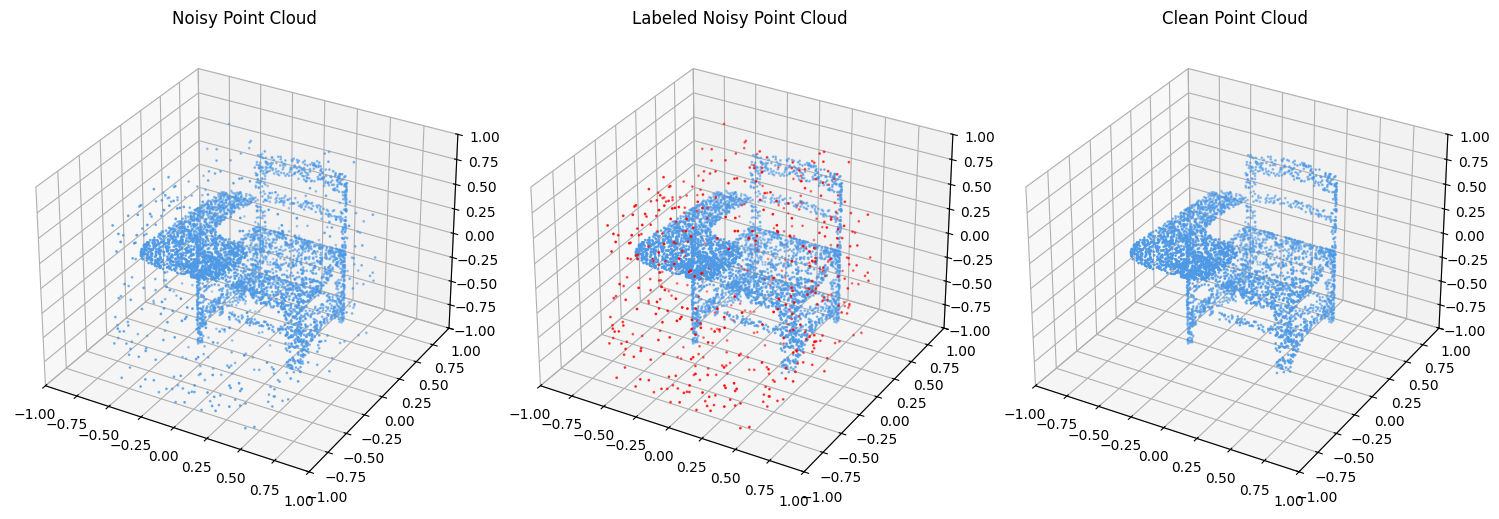

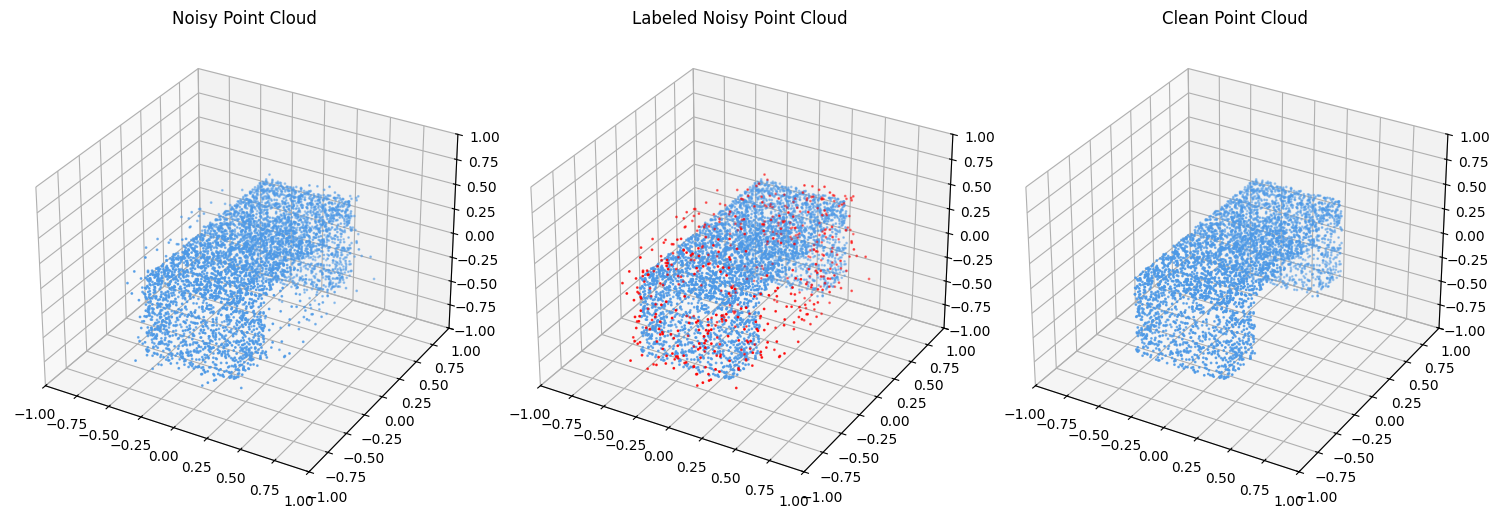

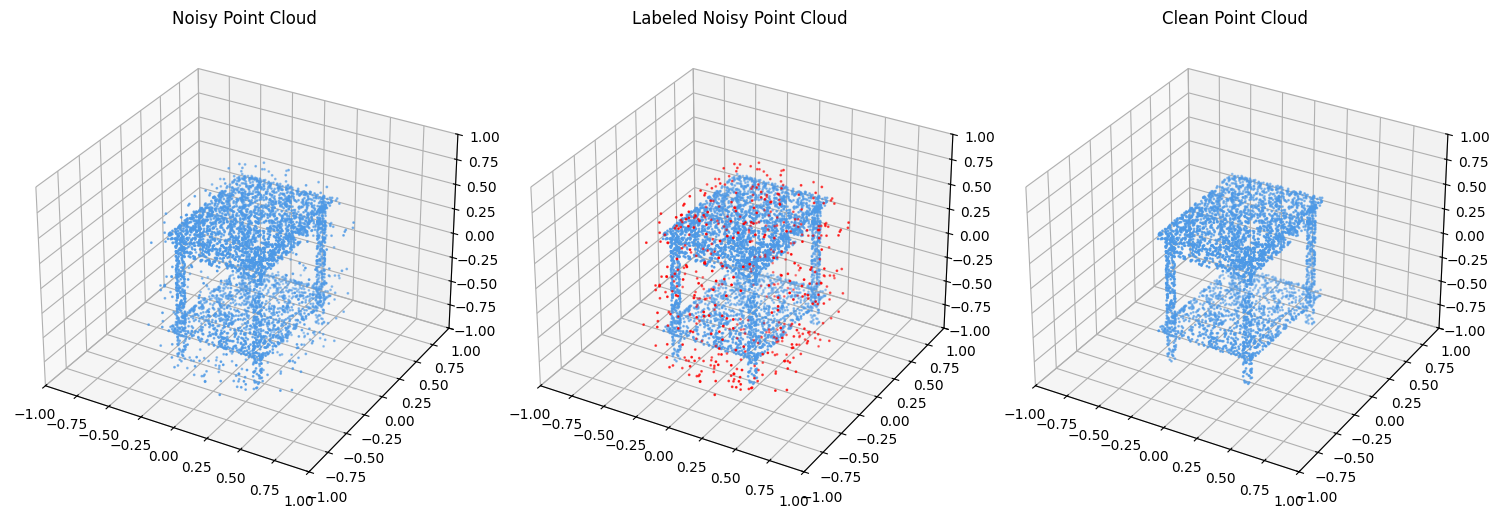

In [151]:
example_indexes = [4, 305, 800, 1805, 3000]

for idx in example_indexes:
    DatasetUtils.plot_example(dataset[idx]["input"], dataset[idx]["output"])
    if INTERACTIVE_VISUALIZATION:
        DatasetUtils.visualize_noisy_pointcloud(dataset[idx]["input"], dataset[idx]["output"])

In [212]:
import matplotlib.pyplot as plt
import torch

def predict_on_noisy_pcd(model, noisy_pcd: torch.Tensor, label: torch.Tensor):
    """Run the model on a noisy point cloud to get predictions"""
    

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model.eval()
    noisy_pcd = noisy_pcd.to(device)
    
    noisy_pcd = noisy_pcd.unsqueeze(0)  # Shape: (1, num_points, 3)

    with torch.no_grad():
        predictions = model(noisy_pcd)

    predicted_labels = (predictions > 0.5).float()

    return predicted_labels.squeeze(0), label


def plot_predictions(noisy_pcd: torch.Tensor, predicted_labels: torch.Tensor, true_labels: torch.Tensor):
    """
    Plot the input noisy point cloud, predicted clean point cloud, and predicted labels.

    Args:
        noisy_pcd (torch.Tensor): The input noisy point cloud of shape (num_points, 3).
        predicted_labels (torch.Tensor): The predicted labels for the noisy point cloud of shape (num_points,).
        true_labels (torch.Tensor): The true labels for the noisy point cloud of shape (num_points,).
    """
    
    # Move tensors to CPU and convert to numpy for visualization
    noisy_pcd_np = noisy_pcd.cpu().numpy()
    predicted_labels_np = predicted_labels.cpu().numpy()
    true_labels_np = true_labels.cpu().numpy()

    # Create a figure with 3 subplots
    fig = plt.figure(figsize=(18, 6))

    # Plot the noisy point cloud
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax1.scatter(noisy_pcd_np[:, 0], noisy_pcd_np[:, 1], noisy_pcd_np[:, 2], c='skyblue', s=1)
    ax1.set_title('Noisy Point Cloud')
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([-1, 1])
    ax1.set_zlim([-1, 1])

    # Plot true labels (clean vs noise)
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    scatter_true = ax2.scatter(noisy_pcd_np[:, 0], noisy_pcd_np[:, 1], noisy_pcd_np[:, 2], 
                                c=true_labels_np, cmap='bwr', s=1, alpha=0.7, vmin=0, vmax=1)
    ax2.set_title('Ground Truth Labels')
    ax2.set_xlim([-1, 1])
    ax2.set_ylim([-1, 1])
    ax2.set_zlim([-1, 1])

    # Plot predicted labels
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    scatter_pred = ax3.scatter(noisy_pcd_np[:, 0], noisy_pcd_np[:, 1], noisy_pcd_np[:, 2], 
                                c=predicted_labels_np, cmap='bwr', s=1, alpha=0.7, vmin=0, vmax=1)
    ax3.set_title('Predicted Labels')
    ax3.set_xlim([-1, 1])
    ax3.set_ylim([-1, 1])
    ax3.set_zlim([-1, 1])

    plt.tight_layout()
    plt.show()

    
def output_predicted_pcd(noisy_pcd: torch.Tensor, predictions: torch.Tensor):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    noisy_pcd = noisy_pcd.to(device)
    predictions = predictions.to(device)

    if predictions.dim() != 1 or predictions.size(0) != noisy_pcd.size(0):
        raise ValueError("Predictions must have shape (num_points,) matching the number of points in noisy_pcd")

    clean_mask = predictions > 0.5

    predicted_pcd = noisy_pcd[clean_mask]

    return predicted_pcd


## Train/Test Split

Now that we have our dataset, let's go ahead and split it into training and testing splits. We will choose a split of about 80% training examples and 20% testing examples

In [213]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_size = 4000
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


## Models

Now we can create the architecture for our models. We will start with a very simple model and continue on to a model that implements point net

#### Basic Model
Let's start with a basic convolutional model. We will implement the model architecture, its training loop, as well as a function to make predictions using the trained model

In [214]:
import torch.nn as nn

class PointNetDenoiser(nn.Module):
    def __init__(self):
        super(PointNetDenoiser, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Conv1d(1024, 512, 1)
        self.fc2 = nn.Conv1d(512, 256, 1)
        self.fc3 = nn.Conv1d(256, 1, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Input: (B, N, 3) -> (B, 3, N)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))

        x = self.relu(self.fc1(x))  # (B, 512, N)
        x = self.dropout(self.relu(self.fc2(x)))  # (B, 256, N)
        
        x = self.fc3(x)  # (B, 1, N) - per-point binary prediction
        x = x.squeeze(1)  # Remove the channel dimension, now (B, N)

        return x

#### Basic model training loop

In [215]:
import torch
import torch.optim as optim
from tqdm import tqdm


def train_basic_model(model: PointNetDenoiser, epochs: int):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()
    
    num_epochs = epochs
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for entry in train_loader_tqdm:
            points = entry["input"].to(device)
            labels = entry["output"].to(device)

            optimizer.zero_grad()
            outputs = model(points) # Shape (B, N)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_loader_tqdm.set_postfix(loss=running_loss / (train_loader_tqdm.n + 1))

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for entry in tqdm(test_loader, desc="Evaluating", unit="batch"):
                points = entry["input"].to(device)
                labels = entry["output"].to(device)

                outputs = model(points)  # Shape (B, N)
                predicted = (torch.sigmoid(outputs) > 0.5).float()

                total += labels.numel()
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {accuracy:.4f}')


#### Run Inference Using Basic Model

In [216]:
def base_model_predict(model: PointNetDenoiser, noisy_pcd_input: torch.Tensor) -> torch.Tensor:
    """make predictions on the given noisy point cloud"""

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model.eval()
    noisy_pcd_input = noisy_pcd_input.to(device)
    noisy_pcd_input = noisy_pcd_input.unsqueeze(0)  # Shape: (1, num_points, 3)

    with torch.no_grad():
        predictions = model(noisy_pcd_input)

    predicted_labels = (predictions > 0.5).float()

    return predicted_labels.squeeze(0)

In [217]:
model = PointNetDenoiser()
train_basic_model(model, 3)

Evaluating: 100%|██████████| 57/57 [00:01<00:00, 50.52batch/s]


Epoch 1/3, Loss: 0.2600, Accuracy: 0.9148


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 52.60batch/s]


Epoch 2/3, Loss: 0.2338, Accuracy: 0.9183


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 52.30batch/s]

Epoch 3/3, Loss: 0.2303, Accuracy: 0.9189


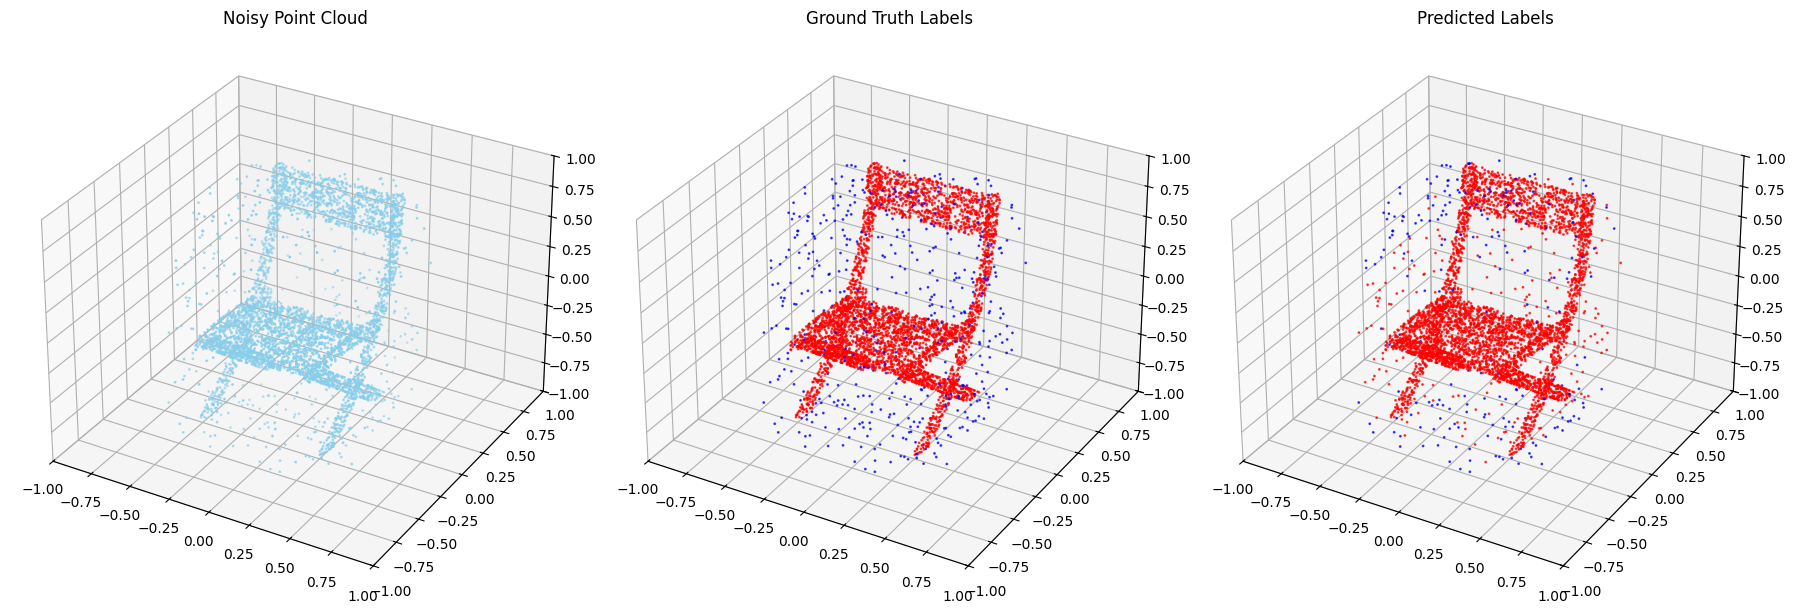

In [218]:
noisy_pcd_input = dataset[1600]["input"]
true_output = dataset[1600]["output"]

predictions = base_model_predict(model, noisy_pcd_input)
plot_predictions(noisy_pcd_input, predictions, true_output)

In [219]:
predicted_pcd = output_predicted_pcd(dataset[1600]["input"], predictions)
DatasetUtils.visualize_pointcloud(predicted_pcd)

===============================================================================

### PointNet Model

Now, lets go ahead and implement a model that utilizes a variation of the PointNet. PointNet uses a layer called a tnet, which effectively learns a transformation matrix that can be applied to the input point cloud. This transformation matrix helps to make point cloud points invariant to permutations, such as rigid transformations. This will allow the model to learn better on point clouds

In [259]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k = k
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k * k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, input):
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))

        init = torch.eye(self.k, requires_grad=True).repeat(bs, 1, 1)
        if xb.is_cuda:
            init = init.cuda()
        matrix = self.fc3(xb).view(-1, self.k, self.k) + init
        return matrix

class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, input):
        matrix3x3 = self.input_transform(input)
        xb = torch.bmm(torch.transpose(input, 1, 2), matrix3x3).transpose(1, 2)

        xb = F.relu(self.bn1(self.conv1(xb)))
        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb, 1, 2), matrix64x64).transpose(1, 2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb)) # (batch_size, 1024, num_points) 
        return xb, matrix3x3, matrix64x64


class PointNet(nn.Module):
    def __init__(self):
        super(PointNet, self).__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Conv1d(256, 1, 1)
        
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, input):

        xb, matrix3x3, matrix64x64 = self.transform(input) # (batch_size, 1024, num_points)

        batch_size, feature_dim, num_points = xb.size()
        xb = xb.transpose(1, 2).contiguous().view(-1, feature_dim) # (batch_size * num_points, 1024)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        xb = xb.view(batch_size, num_points, -1).transpose(1, 2) # (batch_size, 256, num_points)
        
        output = self.fc3(xb).squeeze(1) # (batch_size, num_points)
        
        return output, matrix3x3, matrix64x64


def pointnetloss(outputs, labels, m3x3, m64x64, alpha=0.0001):
    criterion = nn.BCEWithLogitsLoss()
    bs = outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs, 1, 1).to(outputs.device)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs, 1, 1).to(outputs.device)
    
    diff3x3 = id3x3 - torch.bmm(m3x3, m3x3.transpose(1, 2))
    diff64x64 = id64x64 - torch.bmm(m64x64, m64x64.transpose(1, 2))
    
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3) + torch.norm(diff64x64)) / float(bs)



#### PointNet Model Training Loop

In [260]:



def train_pointnet_model(model: PointNetDenoiser, epochs: int):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)


    num_epochs = epochs
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['input'].to(device).float(), data['output'].to(device).float()
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = model(inputs.transpose(1,2))

            if outputs.size() != labels.size():
                labels = labels.view(outputs.size())  # Ensure shape is (batch_size, num_points)

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 9:
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                    (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                running_loss = 0.0

        if test_loader:
            model.eval()
            total, correct = 0, 0
            with torch.no_grad():
                for data in test_loader:
                    inputs, labels = data['input'].to(device).float(), data['output'].to(device).float()
                    outputs, _, _ = model(inputs.transpose(1,2))
                    predicted = (torch.sigmoid(outputs) > 0.5).float()

                    total += labels.numel()
                    correct += (predicted == labels).sum().item()

            val_acc = 100. * correct / total
            print('Validation accuracy: %.2f %%' % val_acc)



#### Run Inference Using PointNet Model

In [261]:
def pointnet_model_predict(model: PointNet, noisy_pcd_input: torch.Tensor) -> torch.Tensor:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    with torch.no_grad():
        output, matrix3x3, matrix64x64 = model(noisy_pcd_input.unsqueeze(0).transpose(1, 2).to(device))
        predictions = (torch.sigmoid(output) > 0.5).float()
    return predictions

In [266]:
pointnet_model = PointNet()
train_pointnet_model(pointnet_model, 5)

[Epoch: 1, Batch:   10 /  250], loss: 0.472
[Epoch: 1, Batch:   20 /  250], loss: 0.315
[Epoch: 1, Batch:   30 /  250], loss: 0.294
[Epoch: 1, Batch:   40 /  250], loss: 0.278
[Epoch: 1, Batch:   50 /  250], loss: 0.259
[Epoch: 1, Batch:   60 /  250], loss: 0.253
[Epoch: 1, Batch:   70 /  250], loss: 0.227
[Epoch: 1, Batch:   80 /  250], loss: 0.228
[Epoch: 1, Batch:   90 /  250], loss: 0.223
[Epoch: 1, Batch:  100 /  250], loss: 0.222
[Epoch: 1, Batch:  110 /  250], loss: 0.233
[Epoch: 1, Batch:  120 /  250], loss: 0.226
[Epoch: 1, Batch:  130 /  250], loss: 0.221
[Epoch: 1, Batch:  140 /  250], loss: 0.212
[Epoch: 1, Batch:  150 /  250], loss: 0.211
[Epoch: 1, Batch:  160 /  250], loss: 0.213
[Epoch: 1, Batch:  170 /  250], loss: 0.204
[Epoch: 1, Batch:  180 /  250], loss: 0.212
[Epoch: 1, Batch:  190 /  250], loss: 0.192
[Epoch: 1, Batch:  200 /  250], loss: 0.205
[Epoch: 1, Batch:  210 /  250], loss: 0.193
[Epoch: 1, Batch:  220 /  250], loss: 0.185
[Epoch: 1, Batch:  230 /  250], 

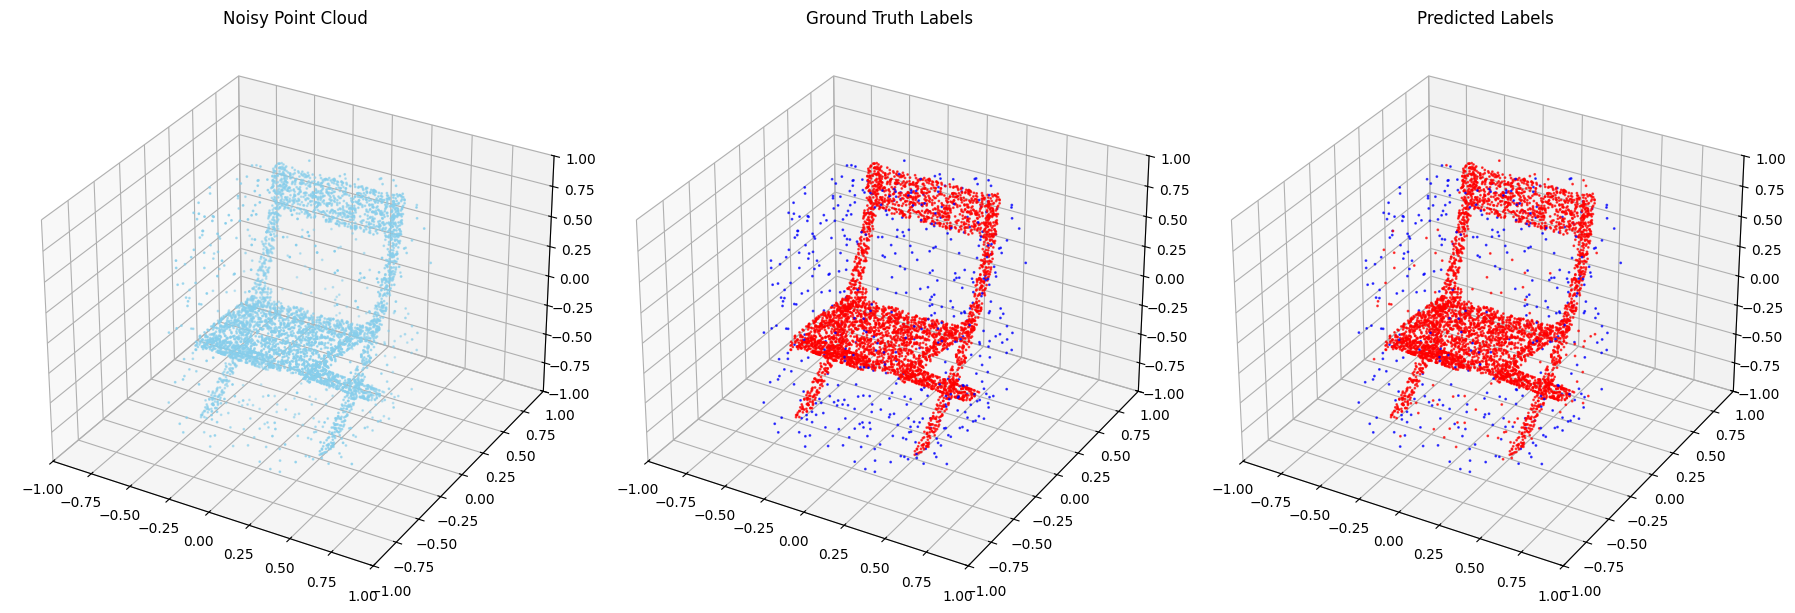

In [267]:
idx = 1600
noisy_pcd_input = dataset[idx]["input"]
true_output = dataset[idx]["output"]

pointnet_predictions = pointnet_model_predict(pointnet_model, noisy_pcd_input)

plot_predictions(noisy_pcd_input, pointnet_predictions, true_output)

In [223]:
#import time

#output_path = f'models/denoise_net_{int(time.time())}.pth'
#torch.save(model.state_dict(), output_path)
#print(f"Model saved as '{output_path}'")

In [268]:
predicted_pcd = output_predicted_pcd(noisy_pcd_input, predictions.squeeze(0))
DatasetUtils.visualize_pointcloud(predicted_pcd)